In [1]:
import os
from pcxarray import pc_query, prepare_timeseries
from pcxarray.utils import load_census_shapefile
from distributed import Client # dask distributed client
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

In [2]:
client = Client(n_workers=os.cpu_count(), memory_limit="2GB")
display(client)

<Client: 'tcp://127.0.0.1:55539' processes=10 threads=10, memory=18.63 GiB>

2025-07-03 19:32:59,389 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:55566 (pid=24955) exceeded 95% memory budget. Restarting...
2025-07-03 19:32:59,521 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:55566' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('array-849a280e7d27c6555623563d607d0430', 0), ('original-open_rasterio-0fe940a7eca6233fe40c4e1389060db5<this-array>-9e9f0108c4e98237a350669cc3860434', 0, 0, 0), 'shuffle-taker-47176decc9916625f019a6a40aad3ae3'} (stimulus_id='handle-worker-cleanup-1751589179.5207622')
2025-07-03 19:32:59,564 - distributed.nanny - WARNING - Restarting worker


In [3]:
okt_gdf = load_census_shapefile(level="county", verify=False)
okt_gdf = okt_gdf[okt_gdf['NAME'] == "Oktibbeha"]
okt_gdf = okt_gdf.to_crs("EPSG:32616") # UTM zone 16N

selected_geom = okt_gdf.geometry.union_all()

In [ ]:
items_gdf = pc_query(
    collections=["sentinel-2-l2a"],
    geometry=selected_geom,
    datetime='2024', # grab all of 2024
    crs=okt_gdf.crs,
    # query={"eo:cloud_cover": {"lt": 50}} # OPTIONAL: filter by cloud cover
)
print(f"Found {len(items_gdf)} items in the query.")

Found 548 items in the query.


In [ ]:
da = prepare_timeseries(
    items_gdf=items_gdf,
    geometry=selected_geom,
    crs=okt_gdf.crs,
    bands=["B02", "B04", "B08", "SCL"], # Blue, Red, NIR, Scene Classification Layer
    # chunks={"time": 1, "x": -1 , "y": -1 }, 
    max_workers=-1, # use all available CPU cores to submit tasks
)
display(da)

Constructing dask computation graph: 100%|██████████| 134/134 [14:44<00:00,  6.60s/timestep]


<xarray.DataArray 'reproject-94620c11b15a4470aa2b5ba9cc9fb21e' (time: 134,
                                                                band: 4,
                                                                y: 3128, x: 3932)> Size: 26GB
dask.array<getitem, shape=(134, 4, 3128, 3932), dtype=float32, chunksize=(1, 1, 3128, 3932), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1kB 2024-01-02 2024-01-05 ... 2024-12-30
    spatial_ref  int32 4B 32616
  * band         (band) <U3 48B 'B02' 'B04' 'B08' 'SCL'
  * y            (y) float64 25kB 3.716e+06 3.716e+06 ... 3.684e+06 3.684e+06
  * x            (x) float64 31kB 3.055e+05 3.055e+05 ... 3.448e+05 3.448e+05
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan

In [6]:
def calculate_evi(da):
    nir = da.sel(band="B08") / 10000
    red = da.sel(band="B04") / 10000
    blue = da.sel(band="B02") / 10000
    
    evi = 2.5 * (nir - red) / (nir + (6 * red) - (7.5 * blue) + 1)
    evi = evi.clip(-1, 1)  # Clip values to [-1, 1]
    return evi

da = da.where(~da.sel(band="SCL").isin([0, 3, 8, 9, 10, 11])) # mask out clouds, shadows, and snow
evi = calculate_evi(da)
monthly_evi = evi.resample(time="1M").median().compute()

2025-07-03 19:31:27,970 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.41 GiB -- Worker memory limit: 1.86 GiB
2025-07-03 19:31:52,560 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.48 GiB -- Worker memory limit: 1.86 GiB
2025-07-03 19:31:52,735 - distributed.worker.memory - WARNING - Worker is at 87% memory usage. Pausing worker.  Process memory: 1.64 GiB -- Worker memory limit: 1.86 GiB
2025-07-03 19:31:52,758 - distributed.worker.memory - WARNING - Worker is at 58% memory usage. Resuming worker. Process memo

RasterioIOError: Read failed. See previous exception for details.

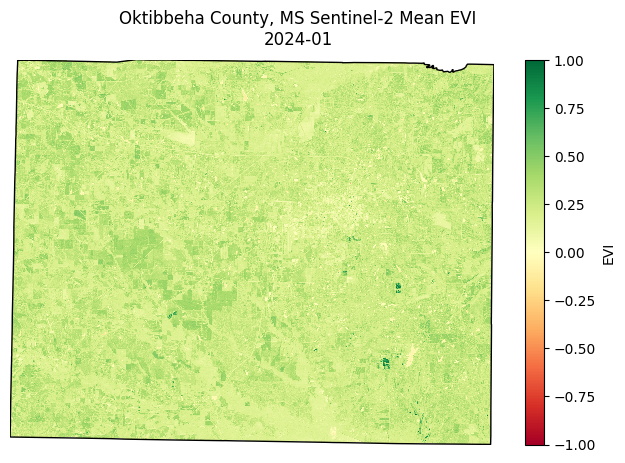

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

def update(frame):
    ax.clear()
    monthly_evi.isel(time=frame).plot.imshow(
        ax=ax, add_colorbar=False, cmap='RdYlGn', vmin=-1, vmax=1
    )

    ax.set_title(None)
    ax.set_aspect('equal')
    ax.axis('off')
    x_lim, ylim = ax.get_xlim(), ax.get_ylim()
    okt_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(ylim)
    
    fig.suptitle(f"Oktibbeha County, MS Sentinel-2 Mean EVI\n" + \
        f"{monthly_evi['time'][frame].dt.strftime('%Y-%m').values}")
    
init_plot = monthly_evi.isel(time=0).plot.imshow(
    ax=ax, add_colorbar=True, cbar_kwargs={'label': 'EVI'},cmap='RdYlGn', vmin=-1, vmax=1
)

ani = FuncAnimation(fig, update, frames=len(monthly_evi['time']), repeat=False)

# show in notebook
HTML(ani.to_jshtml(fps=1, default_mode='once')) 

# plt.close()